<a href="https://colab.research.google.com/github/siruku6/MathematicsTrial/blob/master/easily_understandable_pattern_recognition/chapter9_EM_for_1dim_normal_dist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1次元正規分布の混合正規分布に対する、EMアルゴリズムの適用

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. 正規分布に従うデータの生成

$$
f(x) = \frac{1}{\sqrt{2\pi}} e^{-\frac{x^2}{2}} \\
\\
f(x) = \frac{1}{\sqrt{2\pi} \sigma} e^{\frac{-(x - \mu)^2}{2 \sigma^2}} \\
$$

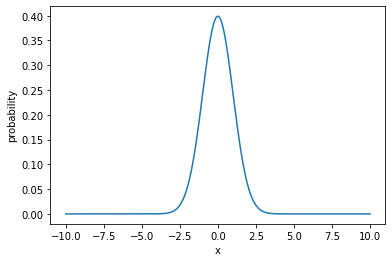

In [2]:
# 標準正規分布
x = np.linspace(-10, 10, 1001)
y = np.exp(- x ** 2 / 2) / np.sqrt(2 * np.pi)
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("probability")
plt.show()

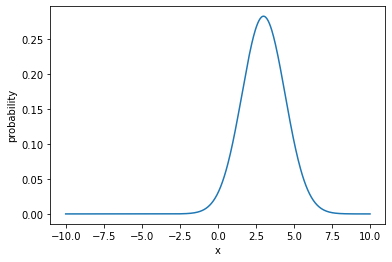

In [64]:
def normal_dist(x: np.ndarray, mu: float, sigma2: float) -> np.ndarray:
    """
    xから、正規分布に従うyを出力する
    """
    denominator = (np.sqrt(2 * np.pi * sigma2)) + 1e-8  # NOTE: to avoid division by zero
    f_x: np.ndarray = (1 / denominator) * np.exp(-(x - mu) ** 2 / (2 * sigma2))
    return f_x



# def gaussian(x, mu, sigma2):
#     return numpy.exp(-0.5 * (x - mu) ** 2 / sigma2) / numpy.sqrt(2 * numpy.pi * sigma2)


mu = 3.0
sigma2 = 2.0
norm_pdf = normal_dist(x, mu, sigma2)
plt.plot(x, norm_pdf)
plt.xlabel("x")
plt.ylabel("probability")
plt.show()

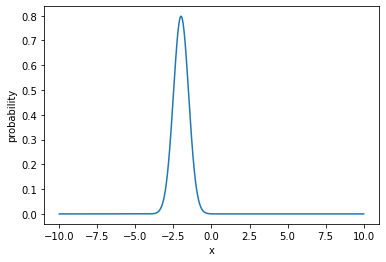

In [ ]:
mu = -2.0
sigma = 0.5

norm_pdf = normal_dist(x, mu, sigma)
plt.plot(x, norm_pdf)
plt.xlabel("x")
plt.ylabel("probability")
plt.show()

## 2. 混合正規分布の生成

$$
p(x) = \sum^K_{k=1} \pi_k N(x | \mu_k, 	\sigma_k)
$$


### 2-1. 確率密度関数

shape: (500,)


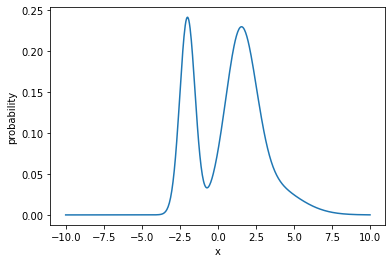

In [32]:
# 前提条件
x = np.linspace(-10, 10, 500)
mu = [3.0, -2.0, 1.5]
sigma = [2.0, 0.5, 1.0]
pi = [0.2, 0.3, 0.5]

# 混合正規分布のデータを生成
norms = [
    normal_dist(x, _mu, _sigma) for _mu, _sigma in zip(mu, sigma)
]
mixed_norm_pdf = norms[0] * pi[0] + norms[1] * pi[1] + norms[2] * pi[2]

print("shape:", mixed_norm_pdf.shape)
plt.plot(x, mixed_norm_pdf)
plt.xlabel("x")
plt.ylabel("probability")
plt.show()

### 2-2. 観測データのサンプリング

In [4]:
def sample_from_mixtured_norm(
    mu_true: np.ndarray, sigma_true: np.ndarray, N: int, pi_true: np.ndarray
) -> np.ndarray:
    """
    Sample data from the mixtured normal distribution at random

    Parameters
    ------
    mu_true: Expectations
        Type: np.ndarray
        Shape: (K,) (K: Number of observed values)
    sigma_true: Variances
        Type: np.ndarray
        Shape: (K,) (K: Number of kinds of Norm dist)
    N: Number of observed values
        Type: int
    pi_true: rate of 
        Type: np.ndarray
        Shape: (K,) (K: Number of kinds of Norm dist)

    Return
    ------
    Shape: (N,) (N: Number of observed values)
    """
    K = len(pi_true)
    assert K == len(mu_true)
    assert K == len(sigma_true)

    org_data = None  # np.empty((np.sum(n), 3))
    for i in range(K):
        print("check: ", i, mu_true[i], sigma_true[i], np.linalg.det(sigma_true[i]))

        size = int(N * pi_true[i])
        # 正規分布から標本をサンプリング
        sampled_data = np.random.multivariate_normal(mean=mu_true[i], cov=sigma_true[i], size=size)

        if org_data is None:
            org_data = np.c_[sampled_data, np.ones(size) * i]
        else:
            org_data = np.r_[org_data, np.c_[sampled_data, np.ones(size) * i]]

    data = org_data[:, 0:-1].copy()
    return data

check:  0 [3] [[1]] 1.0
check:  1 [-1] [[1]] 1.0
shape: (500,)


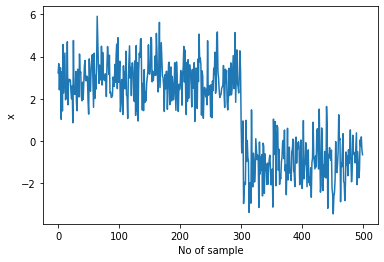

In [5]:
seed = 77
np.random.seed(seed)

N = 500
pi = np.array([ 0.6,  0.4])
mu = np.array([[3], [-1],])
sigma = np.array([[[1]], [[1]],])

sapmled_data = sample_from_mixtured_norm(mu, sigma, N, pi).reshape(-1)
print("shape:", sapmled_data.shape)
plt.plot(sapmled_data)
plt.xlabel("No of sample")
plt.ylabel("x")
plt.show()

(array([ 4.,  4.,  5.,  8., 22., 12., 23., 24., 20., 25., 18., 13.,  7.,
         7., 14., 17., 15., 26., 34., 35., 37., 42., 32., 16., 15.,  9.,
        10.,  4.,  0.,  2.]),
 array([-3.45476624, -3.14267239, -2.83057855, -2.51848471, -2.20639087,
        -1.89429703, -1.58220319, -1.27010934, -0.9580155 , -0.64592166,
        -0.33382782, -0.02173398,  0.29035987,  0.60245371,  0.91454755,
         1.22664139,  1.53873523,  1.85082908,  2.16292292,  2.47501676,
         2.7871106 ,  3.09920444,  3.41129829,  3.72339213,  4.03548597,
         4.34757981,  4.65967365,  4.9717675 ,  5.28386134,  5.59595518,
         5.90804902]),
 <BarContainer object of 30 artists>)

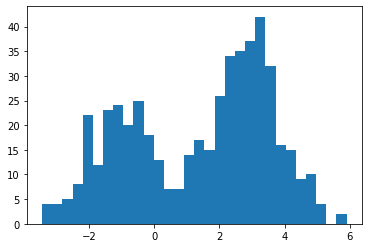

In [65]:
plt.hist(sapmled_data, bins=30)


## 3. 対数尤度関数の計算

$$
\begin{align}
\log {p}(\textbf {x}; \boldsymbol {\theta}) &= \sum^{n}_{k=1} \log p(x_k;\boldsymbol{\theta}) \\
&= \sum^{n}_{k=1} \log {\sum^{c(=3)}_{i=1} \pi_i \mathcal{N}(\mu_i, \sigma_i^2)} ・・・④\\
& \geq \sum^{n}_{k=1} \sum^{c(=3)}_{i=1} \pi_i \log \mathcal{N}(\mu_i, \sigma_i^2) ・・・⑤ \\
&= \sum^{n}_{k=1} \sum^{c(=3)}_{i=1} \pi_i \log{\frac{1}{\sqrt{2\pi} \sigma_i} e^{- \frac{(x_k - \mu_i)^2}{2\sigma^2_i}}} ・・・⑥\\
\end{align}
$$

In [70]:
# ⑤式に従って計算（厳密には尤度ではない）
def _calc_likelihood(
    x: np.ndarray, mu_hat: np.ndarray, sigma_hat: np.ndarray, pi_hat: np.ndarray
) -> np.ndarray:
    """
    Parameters
    ------
    x: observed values
        Type: np.ndarray
        Shape: 1-dimension (Number of observed values)
    mu_hat: Expectations
        Type: np.ndarray
        Shape: 1-dimension (Number of kinds of Norm dist)
    sigma_hat: Variances
        Type: np.ndarray
        Shape: 1-dimension (Number of kinds of Norm dist)
    
    Return
    ------
    Shape: 2-dimension (Number of observed values, Number of kinds of Norm dist)
    """
    norm_pdf = normal_dist(x.reshape(-1, 1), mu_hat, sigma_hat)
    likelihood = pi_hat * np.log(norm_pdf)
    return likelihood


# ④式に従って計算した場合(logの計算は関数外で実行)
def calc_likelihood_2(
    x: np.ndarray, mu_hat: np.ndarray, sigma_hat: np.ndarray, pi_hat: np.ndarray
) -> np.ndarray:
    """
    Parameters
    ------
    x: observed values
        Type: np.ndarray
        Shape: 1-dimension (Number of observed values)
    mu_hat: Expectations
        Type: np.ndarray
        Shape: 1-dimension (Number of kinds of Norm dist)
    sigma_hat: 
        Type: Variances
        Shape: 1-dimension (Number of kinds of Norm dist)
    
    Return
    ------
    Shape: 2-dimension (Number of observed values, Number of kinds of Norm dist)
    """
    norm_pdf = normal_dist(x.reshape(-1, 1), mu_hat, sigma_hat)
    likelihood = pi_hat * norm_pdf
    return likelihood


# 各パラメータの推定値の初期値（仮）
mu_hat = np.array([-2, -3])
sigma_hat = np.array([1, 1])
pi_hat = np.array([0.6, 0.4])

In [67]:
# ⑤式により対数尤度を計算した場合
log_likelihood = _calc_likelihood(sapmled_data, mu_hat.flatten(), sigma_hat.flatten(), pi_hat)
sum_log_likelihood = np.sum(log_likelihood, axis=1)
sum_sum_log_likelihood = np.sum(sum_log_likelihood)

print("shape of log_likelihood: ", log_likelihood.shape)
sum_sum_log_likelihood

shape of log_likelihood:  (500, 2)


-5238.29942012823

In [68]:
# ④式により対数尤度を計算した場合
likelihood = calc_likelihood_2(sapmled_data, mu_hat.flatten(), sigma_hat.flatten(), pi_hat)
sum_likelihood = np.sum(likelihood, axis=1)
log_sum_likelihood = np.log(sum_likelihood)
sum_log_sum_likelihood = np.sum(log_sum_likelihood)

print("shape of log_sum_likelihood: ", log_sum_likelihood.shape)
sum_log_sum_likelihood

shape of log_sum_likelihood:  (500,)


-4678.692474010503

当たり前だけど、計算の順番が sum-log か log-sum かで地味に結果が違う  
KLダイバージェンスの分だけ差があるということらしい

様々な教科書や記事に書かれている通り、 ⑤に基づいて計算したsum-log の結果を終了判定の値として使う  
（せっかく頑張って導出したし）( ˘ω˘)ｽﾔｧ。。。

ただし、負担率の計算のために、④式に従って計算した尤度の関数も利用する

# 4. 負担率の計算

$$
r_{ki} = \frac { \pi_i \mathcal{N}(\mu_i, \sigma_i^2) }{\sum^{c(=3)}_{i=1} \pi_i \mathcal{N}(\mu_i, \sigma_i^2)} ・・・⑪
$$

In [71]:
def calc_responsibility(likelihood):
    return likelihood.T / np.sum(likelihood, axis=1).T


r_i_k = calc_responsibility(likelihood)
r_i_k.shape  # 1次元目 - カテゴリ数 i: 3、2次元目 - 観測されたデータ件数 k: 500

(2, 500)

# 5. 各最尤推定値の計算

$$
\begin{align}
\hat \mu_i &= \frac {\sum^n_{k=1} r_{ki} \cdot x_k}{\sum^n_{k=1} r_{ki}}  \\
&= \frac {1}{N_i}\sum^n_{k=1} r_{ki} \cdot x_k ・・・⑫\\
\\
\hat \sigma^2_i &= \frac{1}{N_i} \sum^n_{k=1} r_{ki} (x_k - \mu_i)^2 ・・・⑮\\
\hat \pi_i &= \frac {\sum^n_{k=1} r_{ki}}{N} = \frac {N_i}{N} ・・・⑲
\end{align}
$$

上記の計算を行いたいが、計算に必要なので、以下も明示しておく

$$
N_i = \sum^n_{k=1} r_{ki}
$$

In [47]:
# N_iを求めておく
N_i = np.sum(r_i_k, axis=1)
print(N_i)

[465.4043453  34.5956547]


In [78]:
# muの最尤推定
tmp_mu_hat = np.sum(r_i_k * x, axis=1) / N_i
tmp_mu_hat

array([-0.40820814,  5.49149433])

In [83]:
# sigma 2乗の最尤推定
x_mu_diff =(x.reshape(-1, 1) - mu_hat).T
tmp_sigma_hat = np.sum(r_i_k * (x_mu_diff ** 2), axis=1) / N_i
tmp_sigma_hat

array([35.3980779 , 81.28158419])

In [58]:
# piの最尤推定
N = len(x)
tmp_pi_hat = N_i / N
tmp_pi_hat

array([0.93080869, 0.06919131])

これで準備は整った

後はこれらを組み合わせるだけ

# 6. EMアルゴリズムのループの組み立て

In [76]:
class EmAlgorithmModel:
    def __init__(self, mu, sigma2, pi):
        """
        Parameters
        ------
        mu: np.ndarray: 1-dim
        sigma2: np.ndarray: 1-dim
            square of sigma (Variance)
        pi: np.ndarray: 1-dim
        """
        # -------------------------------- Step1 --------------------------------
        self.mu_hat = mu
        self.sigma2_hat = sigma2
        self.pi_hat = pi
        # 対数尤度の変化量が 1e-6 以下になったら処理終了
        self.epsilon = 1e-6

    def fit(self, x: np.ndarray) -> dict:
        loop_count = 1
        N = len(x)

        while True:
            prev_likelihood = self.calc_likelihood(x, self.mu_hat, self.sigma2_hat, self.pi_hat)

            # -------------------------------- Step2 --------------------------------
            # 負担率の計算
            r_i_k = self.calc_responsibility(prev_likelihood)

            # -------------------------------- Step3 --------------------------------
            # N_iを求めておく
            N_i = np.sum(r_i_k, axis=1)

            # muの最尤推定
            self.mu_hat = np.sum(r_i_k * x, axis=1) / N_i

            # sigma 2乗の最尤推定
            x_mu_diff = (x.reshape(-1, 1) - self.mu_hat).T
            self.sigma2_hat = np.sum(r_i_k * (x_mu_diff ** 2), axis=1) / N_i

            # piの最尤推定
            self.pi_hat = N_i / N

            # -------------------------------- Step4 --------------------------------
            prev_log_likelihood = self.summation_of_log_likelihood(prev_likelihood)
            new_likelihood = self.calc_likelihood(x, self.mu_hat, self.sigma2_hat, self.pi_hat)
            new_log_likelihood = self.summation_of_log_likelihood(new_likelihood)

            diff = new_log_likelihood - prev_log_likelihood
            print(
                "[{}] Likelihood: {}, Prev Likelihood: {}, Diff: {}, μ_hat: {}, σ^2_hat: {}, π_hat: {}".format(
                    loop_count, new_log_likelihood.round(1), prev_log_likelihood.round(1), diff,
                    self.mu_hat.round(2), self.sigma2_hat.round(2), self.pi_hat.round(2)
                )
            )
            # 対数尤度の変化量が小さくなったら終了
            if (abs(diff) < self.epsilon) or (loop_count > 100):
                break

            loop_count += 1

        return self.return_result()

    def normal_dist(self, x: np.ndarray, mu: float, sigma2: float) -> np.ndarray:
        """
        xから、正規分布に従うyを出力する
        """
        denominator = (np.sqrt(2 * np.pi * sigma2)) + 1e-8  # NOTE: to avoid division by zero
        f_x: np.ndarray = (1 / denominator) * np.exp(-(x - mu) ** 2 / (2 * sigma2))
        return f_x

    def summation_of_log_likelihood(self, likelihood):
        sum_likelihood = np.sum(likelihood, axis=1)
        log_sum_likelihood = np.log(sum_likelihood)
        sum_log_sum_likelihood = np.sum(log_sum_likelihood)
        return sum_log_sum_likelihood

    def calc_likelihood(
        self, x: np.ndarray, mu_hat: np.ndarray, sigma2_hat: np.ndarray, pi_hat: np.ndarray
    ) -> np.ndarray:
        """
        Parameters
        ------
        x: observed values
            Type: np.ndarray
            Shape: 1-dimension (Number of observed values)
        mu_hat: Expectations
            Type: np.ndarray
            Shape: 1-dimension (Number of kinds of Norm dist)
        sigma_hat: 
            Type: Variances
            Shape: 1-dimension (Number of kinds of Norm dist)
        
        Return
        ------
        Shape: 2-dimension (Number of observed values, Number of kinds of Norm dist)
        """
        norm_pdf = normal_dist(x.reshape(-1, 1), mu_hat, sigma2_hat)
        likelihood = pi_hat * norm_pdf
        return likelihood

    def calc_responsibility(self, likelihood) -> np.ndarray:
        return likelihood.T / np.sum(likelihood, axis=1).T

    def return_result(self) -> dict:
        return {
            "mu_hat": self.mu_hat,
            "sigma_hat": self.sigma2_hat,
            "pi_hat": self.pi_hat,
        }


# -------------------------------- 前提条件 --------------------------------
# 観測データ生成
n = np.array([300, 200])
N = np.sum(n)
real_mu = np.array([[3.0], [-1.0]])
real_sigma2 = np.array([[[1.0]], [[1.0]]])
real_pi = n / N
data = sample_from_mixtured_norm(real_mu, real_sigma2, N, n / np.sum(n))


# 初期値
mu = np.array([-2.0, -3.0])
sigma2 = np.array([0.5, 1.5])  # sigma2は、標準偏差(σ)じゃなくて分散(σ^2)です
pi = np.array([0.2, 0.8])


# -------------------------- EMアルゴリズム実行開始 --------------------------
model = EmAlgorithmModel(mu=mu, sigma2=sigma2, pi=pi)
model.fit(data.reshape(-1))

check:  0 [3.] [[1.]] 1.0
check:  1 [-1.] [[1.]] 1.0
[1] Likelihood: -1067.9, Prev Likelihood: -4611.7, Diff: 3543.8036088836748, μ_hat: [-1.22  1.74], σ^2_hat: [0.49 4.16], π_hat: [0.11 0.89]
[2] Likelihood: -1061.3, Prev Likelihood: -1067.9, Diff: 6.619865182518424, μ_hat: [-1.32  1.85], σ^2_hat: [0.43 3.91], π_hat: [0.14 0.86]
[3] Likelihood: -1056.0, Prev Likelihood: -1061.3, Diff: 5.254517794034882, μ_hat: [-1.38  1.95], σ^2_hat: [0.41 3.63], π_hat: [0.16 0.84]
[4] Likelihood: -1051.5, Prev Likelihood: -1056.0, Diff: 4.497527949575897, μ_hat: [-1.41  2.06], σ^2_hat: [0.42 3.35], π_hat: [0.19 0.81]
[5] Likelihood: -1047.2, Prev Likelihood: -1051.5, Diff: 4.281605221589416, μ_hat: [-1.41  2.16], σ^2_hat: [0.44 3.07], π_hat: [0.21 0.79]
[6] Likelihood: -1042.9, Prev Likelihood: -1047.2, Diff: 4.359132607927677, μ_hat: [-1.4   2.25], σ^2_hat: [0.47 2.79], π_hat: [0.23 0.77]
[7] Likelihood: -1038.4, Prev Likelihood: -1042.9, Diff: 4.491178873872741, μ_hat: [-1.38  2.34], σ^2_hat: [0.51

{'mu_hat': array([-0.99046833,  2.90094799]),
 'sigma_hat': array([0.86144887, 1.16206443]),
 'pi_hat': array([0.38378075, 0.61621925])}

1次元の混合正規分布のEMアルゴリズムを実装する分には、  
Q関数という概念を持ち出さなくても計算を行うことができた。

# 参考

- [numpy.random.multivariate_normal](https://analytics-note.xyz/programming/python-multivariate-normal-rvs/)  
- [pythonで混合正規分布実装](https://qiita.com/taka256/items/3e8b127620ac92a32864#python%E3%81%A7%E3%81%AE%E5%AE%9F%E8%A3%85)  
他の方によるEMアルゴリズムの実装。  
実装という観点で言うと、私にはこれが一番参考になりました。
- [EMアルゴリズム徹底解説](https://qiita.com/kenmatsu4/items/59ea3e5dfa3d4c161efb)  
理論面ではこちらが参考になりました。